## Importing json file and preproccessing data

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


####################################
# Function that extracts the jaccard variables and tones
# into two different dataframes
#
# Param: Str:= filepath to json file 
#
#Return: Two DF's = (Jaccard Variables, Tones)
####################################
def json_to_dataframe(file_name :str):
    # Opening and loading jaccard distance tri-tone file
    file = open(file_name)
    #imported as a dict
    data = json.load(file)
    file.close()
    # converting dict to pd.DataFrame 
    df2 = pd.DataFrame.from_dict(data, orient='index')
    # only pulling out tone because thats our label
    tones = pd.DataFrame(df2.tone)
    ##########################
    #print(df2) # to see issue
    ##########################

    # convert vectory array to list so that each vector has its own column
    jaccard_df = pd.DataFrame(df2.vec.tolist())

    # # merging tones and new dataframe together
    # jaccard_df = pd.DataFrame(np.hstack([dataframe, tones])) # use np.hstack instead of pd.concat becuase of error issues
    # #rename last column to Tone
    # jaccard_df.rename(columns={jaccard_df.columns[332]: "Tone"}, inplace=True)
    # jaccard_df 
    
    # Our feature
    return (jaccard_df, tones)



##############################
# Categorically encodes the tones 
# to negative: 0, neural: 1, and positive: 2
# 
# Param: DF:= Tones Label 
#
# Return: tones encoded
#############################
def category_encode(tones): 
    t = pd.Categorical(tones['tone'])
    tones['tone'] = t.codes
    return tones

In [2]:
jaccard_df, tones = json_to_dataframe('clean_tri_tone_synthetic.json')

# Categorically encoding negative: 0, neutral: 1,  positive: 2
tones = category_encode(tones)

## SVM Implementation

In [3]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

X_jacc_words = jaccard_df.to_numpy()

Y_label = tones.to_numpy()
####################################
# Fits an SVC model and runs a prediction 
# test 
#
# Params:
#   X := features (jaccard distance variables)
#   Y := Labels (Tones)
#   test_size := Training and testing split. Set to %30
#
# Return: Accuracy score of SVC
####################################
def SVC_model(X, y, test_size = 0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


    model_clf = svm.SVC(kernel='linear').fit(X_train, np.ravel(y_train))
    predicted = model_clf.predict(X_test)

    return accuracy_score(y_test, predicted)


In [4]:
print(SVC_model(X_jacc_words, Y_label, 0.3))

0.9977777777777778


## PCA

In [5]:
##################################
# PCA 
# 
#
##################################

def dimension_reduction_by_PCA(X, components):
    pca = PCA(n_components=components).fit(X)
    # print(pca.explained_variance_)
    return pca.fit_transform(X)

In [6]:
pca_X = dimension_reduction_by_PCA(X_jacc_words, 4)
print(SVC_model(pca_X, tones))

0.9977777777777778


## Plotting PCA

In [7]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

################################
# We plot the SVC according to how many 
# PCA components we have 
#
# Params: 
#   X := Features (Components returned from PCA)
#   Y := Lables (Tones)
#   First_c := First component to choose 
#   Second_x := Second component to choose 
#
# Return: Plots the SVC 
################################
def plotting_PCA_SVC(X, y, first_c, second_c):

    first = X[:, first_c].reshape((X.shape[0], 1))
    second = X[:, second_c].reshape((X.shape[0], 1))
    X = np.concatenate((first, second), axis = 1)

    model = svm.SVC(kernel='linear')
    clf = model.fit(X, np.ravel(y))

    fig, ax = plt.subplots()
    # title for the plots
    title = ('Pure Data SVC using PCA ')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    colors = {0: 'red', 1:'grey', 2: 'blue'}

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('PC' + str(second_c))
    ax.set_xlabel('PC' + str(first_c))
    ax.set_xticks((-0.085, 0.085))
    ax.set_yticks((-0.085, 0.085))
    ax.set_title(title)
    ax.legend()
    plt.axis([-0.085, 0.085, -0.085, 0.085])
    plt.savefig('Pure-PCA_Brian.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


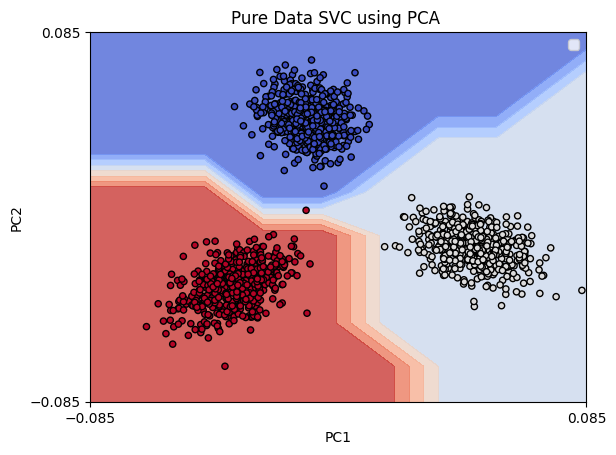

In [8]:
plotting_PCA_SVC(pca_X, Y_label, first_c = 1, second_c = 2)

## Cross Contamination

In [9]:
cross_df = pd.read_csv('cross-contamination.csv')
y_label = pd.DataFrame(cross_df['Tone'])
t = pd.Categorical(y_label['Tone'])
y_label['Tone'] = t.codes
y = y_label.to_numpy()

cross_df = cross_df.drop(columns=['Tone'])
X_cross = cross_df.to_numpy()

In [10]:
pca_cross = dimension_reduction_by_PCA(X_cross, 4)
SVC_model(pca_cross, y_label)

0.9966666666666667

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


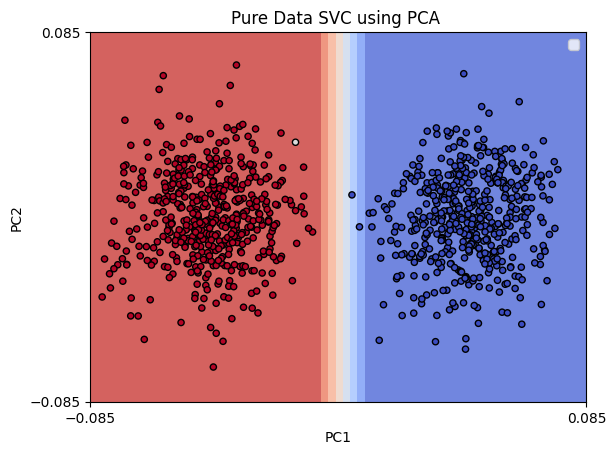

In [11]:
plotting_PCA_SVC(pca_cross, y, first_c = 1, second_c = 2)

Support Vector Classifier (SVC) is a generalized classification model that is an extension of the maximal marginal classifier. A Support Vector Machine is an extension of the SVC to accomodate non-linear boundaries. SVM's seperate the data by finding the optimal seperating hyperplane, which is the hyplane that is furthest from the training observation. The difference between SVC and SVM, is allwoing observations to cross the hyperplane. In our work, we applied SVC's becuase we want to classify if a sentence is negative, positive, and neurtal and find the best hyperplane. However, as we contaminate and add more noise to our data we apply SVM's to allow the overlap of data points. What we want is to observe and achieve how well our accuracy becomes after large amount of noise and cross contamination, and what can be explained from these results. We have show two plots on our pure data and cross contaminated data. 

## Incrementing the feature set by 10% and running 10 test to find its average accuracy and standard deviation 

In [13]:
# Seperate feature and labels
pure_df, tones = json_to_dataframe('clean_tri_tone_synthetic.json')

# Categorically encoding negative: 0, neutral: 1,  positive: 2
tones = category_encode(tones)

In [57]:
import seaborn as sns

inc_10 = [0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
acc_score = []
for fraction in inc_10: 
    curr_acc_list = []
    for i in range(10):
        df = pure_df.sample(frac= fraction, axis='columns')
        curr_acc_list.append(SVC_model(df, tones))
    acc_score.append(curr_acc_list)

acc = np.array(acc_score).T


accuracy_df = pd.DataFrame(acc, columns=["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"])

Text(0.5, 1.0, "Boxplot Comparing the Different Accuracy's Incrementing Features")

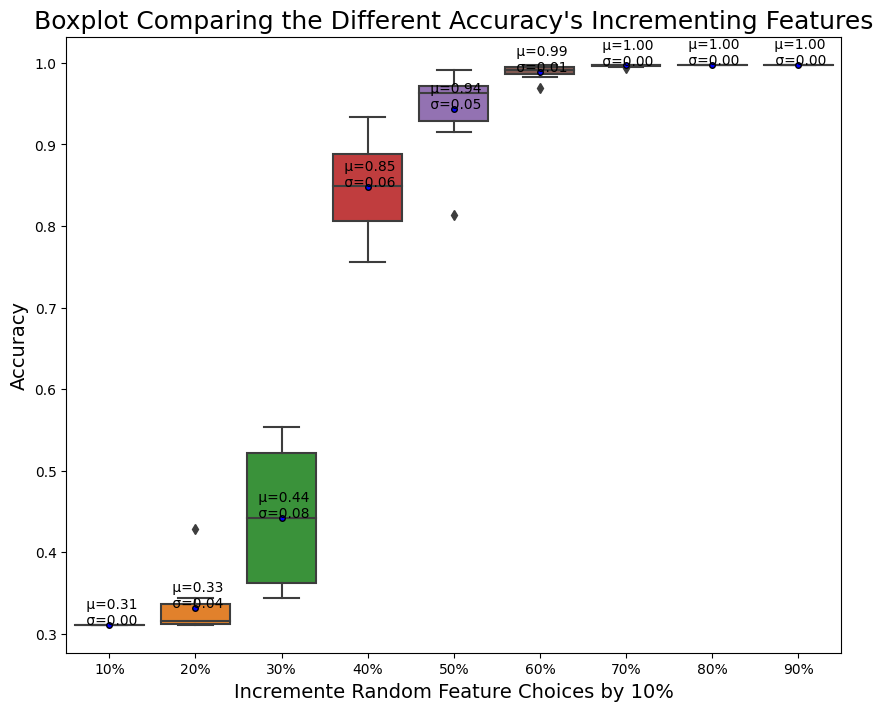

In [70]:
mean = accuracy_df.mean()
std = accuracy_df.std()

plt.figure(figsize=(10,8))
bp = sns.boxplot(data=accuracy_df, showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "blue",
                "markeredgecolor": "black",
                "markersize": "4"
            })
for i in range(len(mean)):
    bp.annotate(
        ' μ={:.2f}\n σ={:.2f}'.format(mean[i], std[i]), 
        xy=(i, mean[i]), 
        horizontalalignment='center'
    )
plt.ylabel("Accuracy", size= 14)
plt.xlabel("Incremente Random Feature Choices by 10%", size = 14)
plt.title("Boxplot Comparing the Different Accuracy's Incrementing Features", size = 18)
